# n-step SARSA in Gridworld

## Goal:

- implement n-step SARSA

In [1]:
import gym
import chula_rl as rl
import os
import numpy as np
import random
from collections import deque, defaultdict
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt

## Step 1: Make Env

In this exercise, we would use a much larger enivornment.

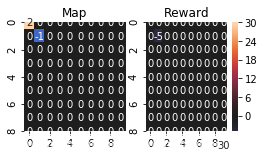

In [2]:
def make_env():
    env = rl.env.Gridworld(shape=(10, 10), start=(0, 0), goal=(9, 9), goal_reward=30)
    env = rl.env.wrapper.ClipEpisodeLength(env, n_max_length=30)
    env = rl.env.wrapper.EpisodeSummary(env)
    return env


env = make_env()
env.reset()
env.render()

## Step 2: Define many-step explorer

This explorer should take "n" steps in the environment, then returns the data observed.

If during "n" steps the environment terminates, just restart the environment and continue. Always returning "n" steps worth of experience. 

In [3]:
class ManyStepExplorer(rl.explorer.BaseExplorer):
    def __init__(self, n_step: int, n_max_interaction: int, env: gym.Env):
        super().__init__(env)
        self.n_step = n_step
        self.n_max_interaction = n_max_interaction

        self.last_s = self.env.reset()
        self.n_interaction = 0
        self.n_ep = 0

    def step(self, policy):
        data = defaultdict(list)
        for _ in range(self.n_step):
            if self.n_interaction > self.n_max_interaction:
                raise rl.exception.InteractionExceeded()
                
            # code here ...
            a = policy.step(self.last_s)
            s, r, done, info = self.env.step(a)
            self.n_interaction += 1
            
            #print(self.last_s)
            
            data['s'].append(self.last_s)
            #print("data_state = ",data['state'])
            data['a'].append(a)
            data['r'].append(r)
            data['done'].append(done)
            
            self.last_s = s

            if done:
                # hint: reset and continue
                self.last_s = self.env.reset()
                self.n_ep += 1
                self._update_stats(self.n_interaction, info['episode']['reward'])
        data['final_s'] = self.last_s
        final_a = policy.step(self.last_s)
        data['final_a'] = final_a
        return data


Test the many-step explorer

In [4]:
rl.util.set_seed(0)
agent = rl.policy.RandomPolicy(env.action_space.n)
explorer = ManyStepExplorer(n_step=3, n_max_interaction=100, env=env)
for i in range(3):
    data = explorer.step(agent)
    
print('states:')
print(np.array(data['s']))
print('actions:', np.array(data['a']))
print('rewards:', np.array(data['r']))
print('dones:', np.array(data['done']))
print('final_s:', data['final_s'])
print('final_a:', data['final_a'])

states:
[[1 4]
 [2 4]
 [2 3]]
actions: [2 1 1]
rewards: [-1 -1 -1]
dones: [False False False]
final_s: [2 2]
final_a: 2


Expected result: 

```
states:
[[2 1]
 [2 0]
 [3 0]]
actions: [1 2 2]
rewards: [-1 -1 -1]
dones: [False False False]
final_s: [4 0]
final_a: 0
```

Yours could differ, but the structure should be the same.

## Step 3: Define N-step SARSA policy

Our n-step SARSA would recieve "n" steps worth of experience each time. 

That is we could construct from **1-step return to n-step returns**. 

We would use all of these not just the n-step return!

In [5]:
def make_returns(r, done, final_q, discount_factor):
    """returns n-step return to 1-step return"""
    # code here ...
    g = []
    for i in range(len(r)):
        gi = 0
        count = 0
        plus = True
        for j in range(i,len(r)):
            if(done[j]):
                plus = False
                gi += (discount_factor**count)*r[j]
                break
            gi += (discount_factor**count)*r[j]
            count +=1
        if(plus):# when done not include bootstraping
            gi += (discount_factor**count)*final_q
        g.append(gi)
    return np.array(g)

Test make_returns

In [6]:
make_returns(
    [1., 1., 1.],
    [False, False, False],
    1.,
    0.9
)

array([3.439, 2.71 , 1.9  ])

Expected result: `array([3.439, 2.71 , 1.9  ])`

Test make_returns

In [7]:
make_returns(
    [1., 1., 1.],
    [False, True, False],
    1.,
    0.9
)

array([1.9, 1. , 1.9])

Expected result: `array([1.9, 1. , 1.9])`

Define the policy

In [8]:
class NStepSARSAPolicy(rl.policy.BasePolicy):

    def __init__(self, lr, discount_factor, observation_space, n_action):
        self.lr = lr
        self.discount_factor = discount_factor
        self.observation_space = observation_space
        self.n_action = n_action

        self.q = np.zeros(list(self.observation_space.high) +
                          [n_action])  # (s0, s1, a)

    def step(self, state):
        # code here 
        #print(np.argmax(self.q[tuple(state)]))
        return np.argmax(self.q[tuple(state)])

    def optimize_step(self, data):
        s = np.array(data['s'])
        a = np.array(data['a'])
        r = np.array(data['r'])
        #print(np.mean(r))
        done = np.array(data['done'])
        final_s = data['final_s']
        final_a = data['final_a']
        # code here
        final_state = (final_s[0],final_s[1],final_a)
        g = make_returns(r,done,self.q[final_state],self.discount_factor)
        for i in range(len(a)):
            current_state = (s[i][0],s[i][1],a[i])
            self.q[current_state] = self.q[current_state] + self.lr*(g[i] - self.q[current_state])

## Training 5-step TD

100%|█████████████████████████████████████████████████████████████████████████| 30000/30000 [00:02<00:00, 10659.10it/s]


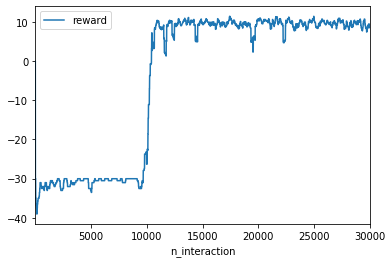

In [10]:
rl.util.set_seed(0)
policy = NStepSARSAPolicy(lr=0.1,
                          discount_factor=0.99,
                          observation_space=env.observation_space,
                          n_action=env.action_space.n)
policy = rl.policy.wrapper.EpsilonGreedy(policy,
                                         eps=0.1,
                                         n_action=env.action_space.n)
explorer = ManyStepExplorer(n_step=5, n_max_interaction=30_000, env=env)
df = rl.trainer.train(explorer, policy, make_env, callbacks=[rl.trainer.ExplorerStatsCb(10)])
df.plot(x='n_interaction', y='reward')

Expected result: something like the following

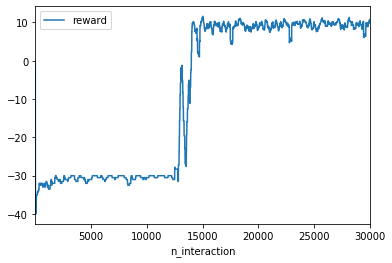

# Comparing with one-step TD

30001it [00:02, 10911.56it/s]                                                                                          


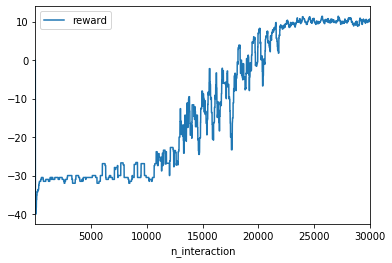

In [11]:
rl.util.set_seed(0)
env = make_env()
policy = rl.policy.tabular.SARSAPolicy(lr=0.1,
                                       discount_factor=0.99,
                                       observation_space=env.observation_space,
                                       n_action=env.action_space.n)
policy = rl.policy.wrapper.EpsilonGreedy(policy,
                                         eps=0.1,
                                         n_action=env.action_space.n)

explorer = rl.explorer.OneStepExplorer(n_max_interaction=30_000, env=env)
df = rl.trainer.train(explorer, policy, make_env, callbacks=[rl.trainer.ExplorerStatsCb(10)])
df.plot(x='n_interaction', y='reward')

Expected result:

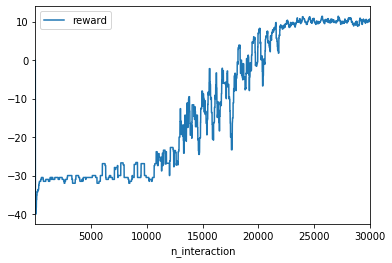

# Q1: How do the results from 5-step TD and 1-step TD differ? Are these expected? How?

Describe here ...
5 step TD จะสามารถไปหา max reward ได้ก่อน 1 step TD แต่ก็มี variance ที่มากกว่าเช่นเดียวกัน